In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import mplhep as hep
import pandas as pd
hep.style.use(hep.style.CMS)

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
import uproot

import warnings

warnings.filterwarnings('ignore')

In [2]:
fname = "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/120000/AAAEC7ED-E488-2C45-A141-A5B36AFAF3D5.root"
events=NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

# SELECCIÓN DE EVENTOS

## Muon

In [3]:
goodmuon = ((ak.sum(events.Muon.pt>0, axis=1)>0)
                &(ak.firsts(events.Muon.pt) > 20)
                & (((0<abs(ak.firsts(events.Muon.eta))) & (abs(ak.firsts(events.Muon.eta))<2.4)))
                & (((1.57<abs(ak.firsts(events.Muon.eta))) | (abs(ak.firsts(events.Muon.eta))<1.4)))
               )

## Jet

In [4]:
goodJets = ((ak.sum(events.Jet.pt>0, axis=1)>0)
            &(ak.firsts(events.Jet.pt)>30)
            &(abs(ak.firsts(events.Jet.eta))<2.4)
             )


## Met

In [5]:
goodMet=events.MET.pt>50


In [6]:
candidate=events[goodmuon & goodJets & goodMet]
candidate

<NanoEventsArray [None, ... <event 1:67041:67040992>] type='725343 * ?event'>

# Gráficos

In [7]:
import mplhep as hep
hep.style.use("CMS")

## Electrón

In [8]:
def plot_cms(data,bines,labels):
    plt.plot(igsize=(12, 4))
    h, bins= np.histogram(data,bins=bines)
    hep.cms.lumitext("(13 TeV)")
    hep.cms.text("Work in Progress")
    hep.histplot(h,bins=bins, density=True,label=labels)
    hep.histplot(h,bins=bins, histtype='errorbar',yerr=True,color="black", density=True,label="Data")
    plt.legend()
    plt.xlabel(labels)


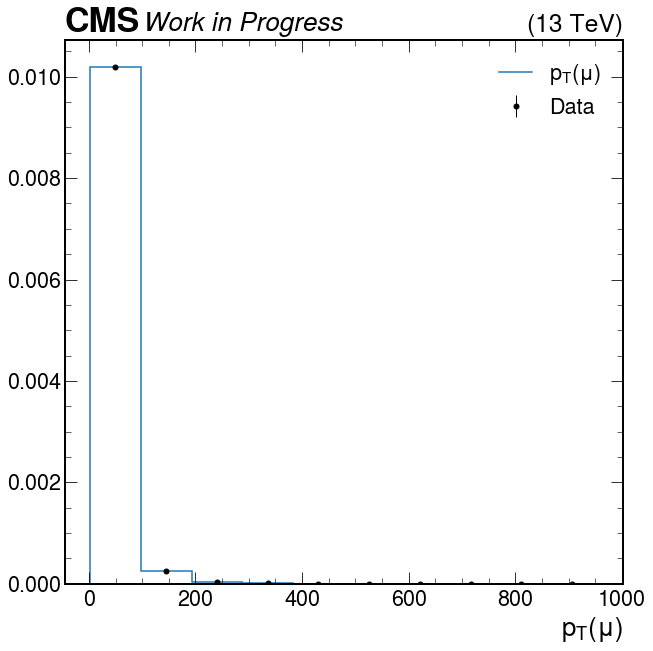

In [10]:
plot_cms(ak.to_numpy(ak.flatten(candidate.Electron.pt)),bines=10,labels="${p}_{T}(\mu)$")

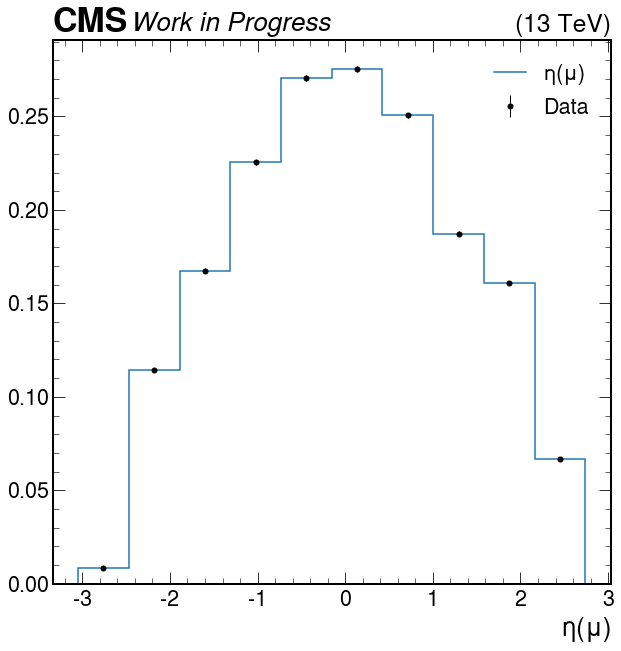

In [11]:
plot_cms(ak.to_numpy(ak.flatten(candidate.Electron.eta)),bines=10,labels="$\eta(\mu)$")

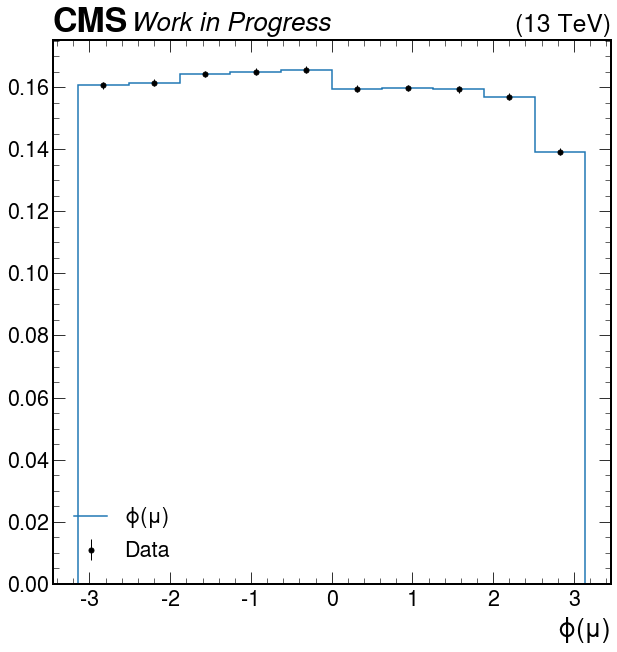

In [12]:
plot_cms(ak.to_numpy(ak.flatten(candidate.Electron.phi)),bines=10,labels="$\phi(\mu)$")

## Jet

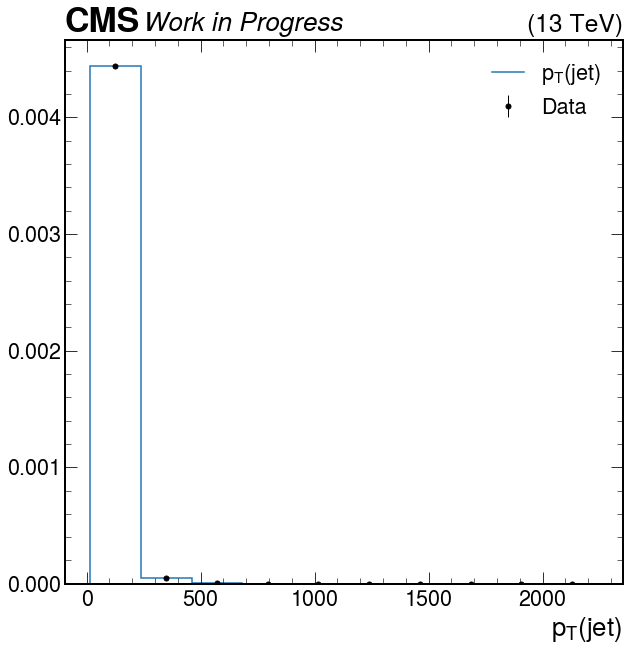

In [13]:
plot_cms(ak.to_numpy(ak.flatten(candidate.Jet.pt)),bines=10,labels="${p}_{T}(jet)$")

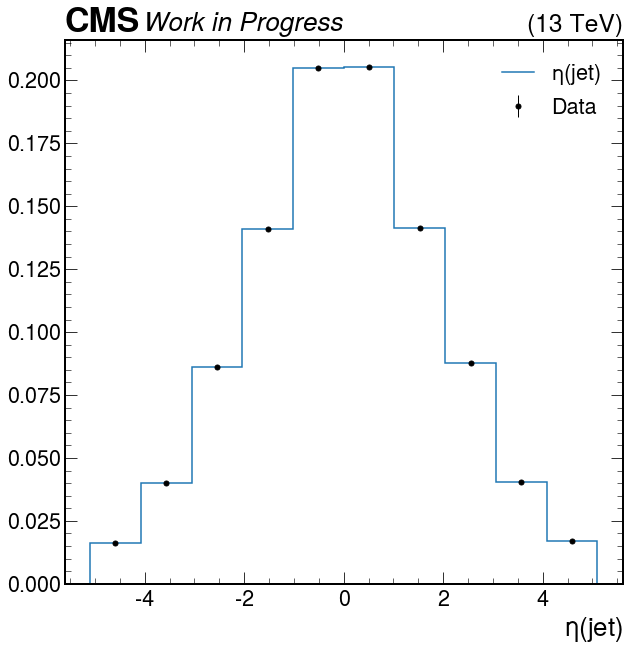

In [14]:
plot_cms(ak.to_numpy(ak.flatten(candidate.Jet.eta)),bines=10,labels="$\eta(jet)$")

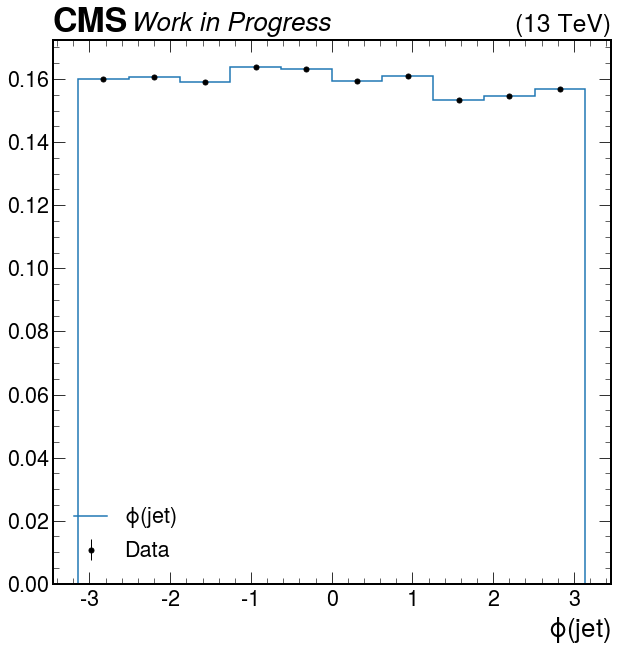

In [15]:
plot_cms(ak.to_numpy(ak.flatten(candidate.Jet.phi)),bines=10,labels="$\phi(jet)$")

## Delta phi Jet and Met

In [16]:
dlata_phi_jet_met=candidate.Jet.delta_phi(candidate.MET)

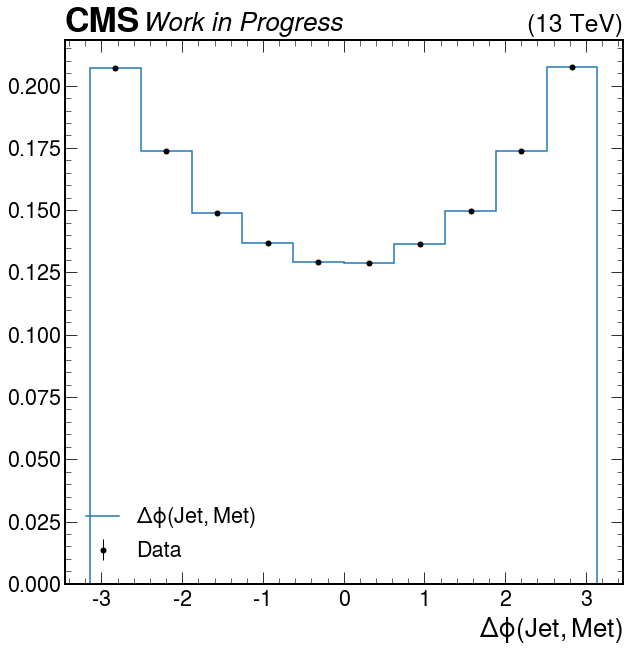

In [17]:
plot_cms(ak.to_numpy(ak.flatten(dlata_phi_jet_met)),bines=10,labels="$\Delta\phi(Jet,Met)$")

## Delta phi Muon and Met

In [20]:
dlata_phi_muon_met=candidate.Muon.delta_phi(candidate.MET)

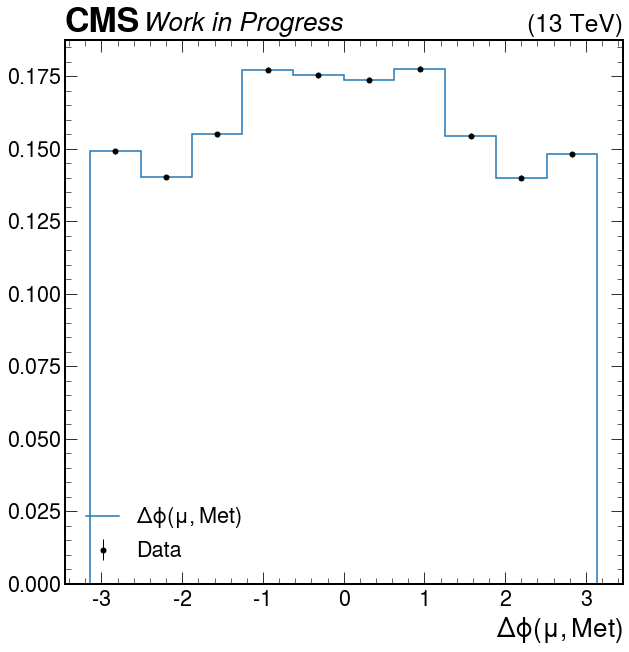

In [22]:
plot_cms(ak.to_numpy(ak.flatten(dlata_phi_muon_met)),bines=10,labels="$\Delta\phi(\mu,Met)$")

## Delta phi jet and Muon

In [24]:
jet = ak.pad_none(
    candidate.Jet, 
    target=4,
    axis=1,
    clip=True
)
muon = ak.pad_none(
    candidate.Muon, 
    target=4,
    axis=1,
    clip=True
)

In [26]:
dlata_phi_jet_muon=jet.delta_phi(muon)

In [27]:
ak.flatten(dlata_phi_jet_muon)

<Array [-2.53, -2.73, None, ... None, None] type='934808 * ?float32'>

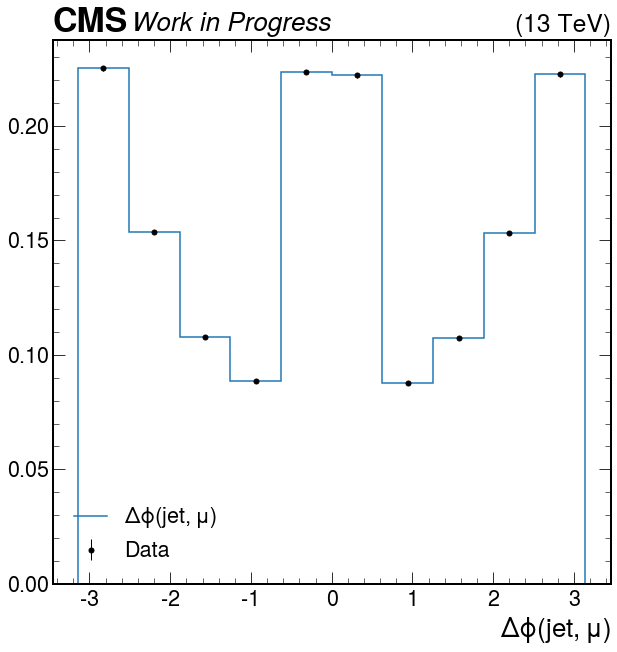

In [29]:
plot_cms(list(filter(None, ak.flatten(dlata_phi_jet_muon))),bines=10,labels="$\Delta\phi(jet,\mu)$")

# transverse mass

In [30]:
def transverse_mass(tau_pt, met_et, deltaphi):
    #Calculates the transverse mass between tau (or any other jet) and the met
    return np.sqrt(2 * tau_pt.pt * met_et.pt * (1 - np.cos(deltaphi)))

## transverse mass between e and the met

In [33]:
mas_muon_met=transverse_mass(candidate.Muon,candidate.MET, dlata_phi_muon_met)

(0.0, 300.0)

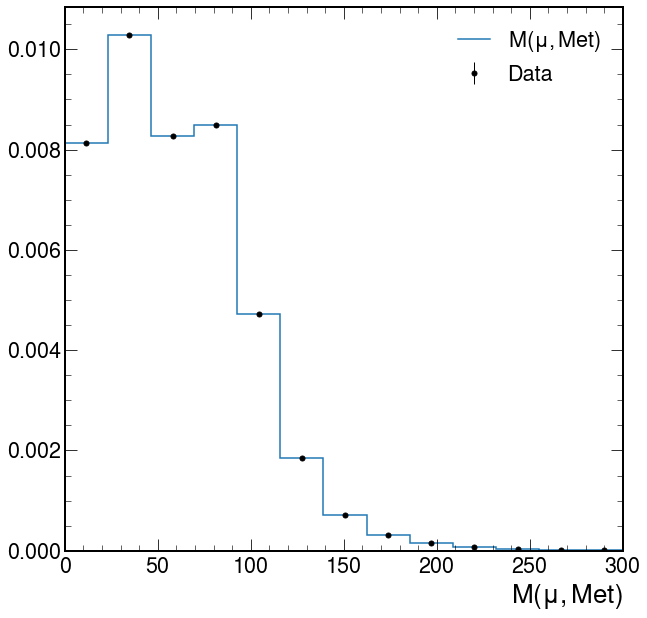

In [38]:
h, bins= np.histogram(ak.to_numpy(ak.flatten(mas_muon_met)),bins=100)
hep.histplot(h,bins=bins, density=True,label="$M(\mu,Met)$")
hep.histplot(h,bins=bins, histtype='errorbar',yerr=True,color="black", density=True,label="Data")
plt.legend()
plt.xlabel("$M(\mu,Met)$")
plt.xlim(0,300)

## transverse mass between jet and the met

In [39]:
mas_jet_met=transverse_mass(candidate.Jet,candidate.MET, dlata_phi_jet_met)

(0.0, 200.0)

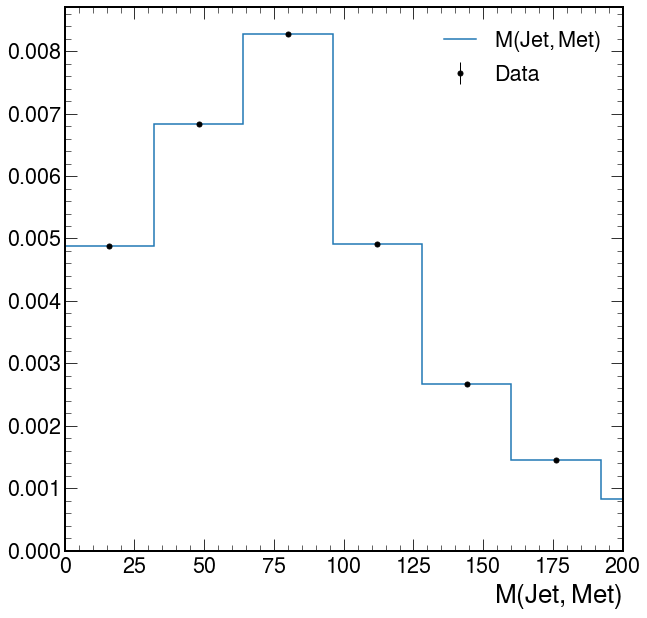

In [40]:
h, bins= np.histogram(ak.to_numpy(ak.flatten(mas_jet_met)),bins=100)
hep.histplot(h,bins=bins, density=True,label="$M(Jet,Met)$")
hep.histplot(h,bins=bins, histtype='errorbar',yerr=True,color="black", density=True,label="Data")
plt.legend()
plt.xlabel("$M(Jet,Met)$")
plt.xlim(0,200)

# mass invariante

In [41]:

def invariant_mass(jet1, jet2):
    return np.sqrt(2 * jet1.pt * jet2.pt * (np.cosh(jet1.eta - jet2.eta) - np.cos(jet1.phi - jet2.phi)))

In [43]:
mas_inv_e_met= list(filter(None, ak.firsts(invariant_mass(jet, muon))))


(0.0, 500.0)

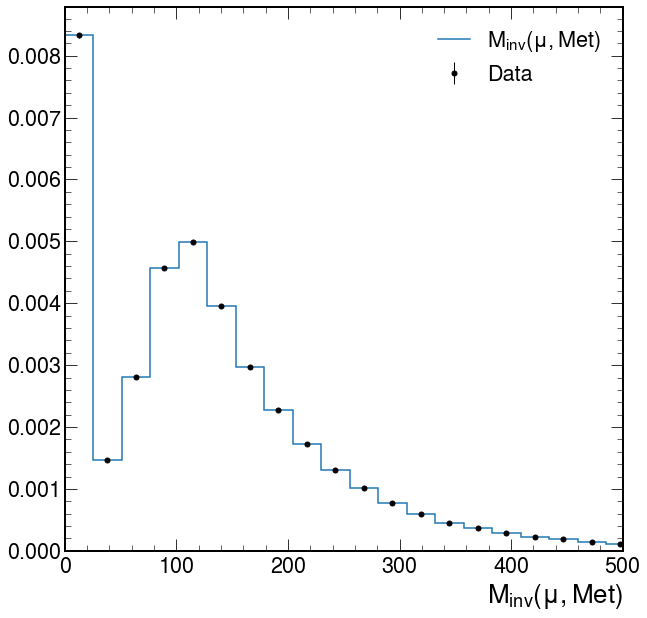

In [45]:
h, bins= np.histogram(mas_inv_e_met,bins=100)
hep.histplot(h,bins=bins, density=True,label="$M_{inv}(\mu,Met)$")
hep.histplot(h,bins=bins, histtype='errorbar',yerr=True,color="black", density=True,label="Data")
plt.legend()
plt.xlabel("$M_{inv}(\mu,Met)$")
plt.xlim(0,500)

## Delta phi 4 Jet

In [46]:
jet = candidate.Jet

jet = ak.pad_none(
    jet, 
    target=4,
    axis=1,
    clip=True
)

jet_events = ak.zip(
    {
            "pt": jet.pt,
            "eta": jet.eta,
            "phi": jet.phi,
            "mass": jet.mass
    },
    with_name="PtEtaPhiMCandidate",
    behavior=candidate.behavior
)

In [47]:
jet_pairs = ak.combinations(jet_events, 2)

In [48]:
jp_one, jp_two = ak.unzip(jet_pairs)

In [49]:
jets_delta_phi = jp_one.delta_phi(jp_two)

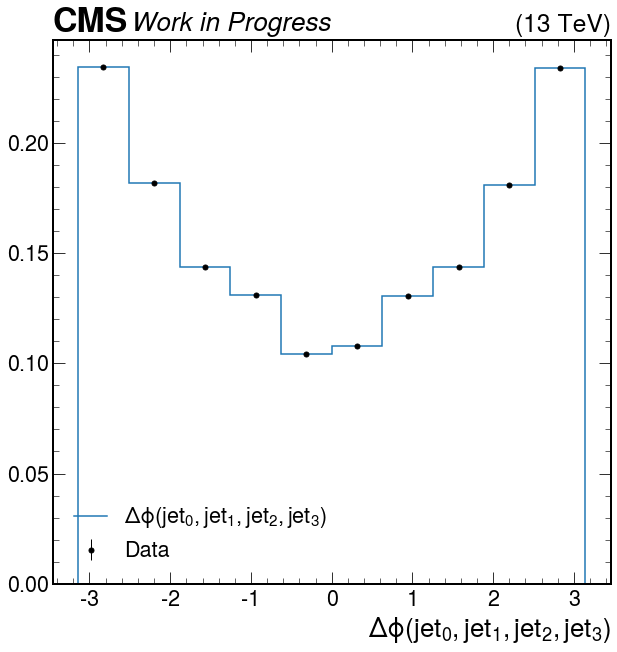

In [50]:
plot_cms(ak.to_numpy(ak.flatten(jets_delta_phi)),bines=10,labels="$\Delta\phi(jet_{0},jet_{1},jet_{2},jet_{3})$")